# Prototypical problem

$$
-u_h''(x) = f(x)\ \mathrm{ in }\ [0,1]
$$

$$
u_h(0) = 0, \quad u_h(1) = 0
$$

We start by considering a uniform discretisation of the interval $[0,1]$ using $n$ equispaced *sample points* (to construct first a **Finite Difference Approximation**).

In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *

n = 9
h = 1./(n-1)

x=linspace(0,1,n)

# Central finite difference approximation

We consider the approximation

$$
-u''_i := \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2}
$$

and solve the linear system

$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad i=1,\ldots,n-2
$$

This results in a tridiagonal matrix with $n-2$ entries. We assemble all of the entries anyway, and then perform a **line elimination** to make the system solvable. This is typical of problems with **Dirichlet Boundary conditions**.

In [2]:
a = -ones((n-1,)) # Offdiagonal entries
b = 2*ones((n,)) # Diagonal entries
A = (diag(a, -1) + diag(b, 0) + diag(a, +1))
print(A)

# Now we scale it to 1/h^2
A /= h**2
print(linalg.cond(A))

[[ 2. -1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  2.]]
39.8634581891


Now let's consider a simple right hand side:

$$
f_i = 4\pi^2 \sin(2\pi x_i)
$$

With this right hand side, the exact solution is given by 

$$
u = \sin(2\pi x)
$$

Let's see what error we make, by approximating the second derivative using central finite difference:

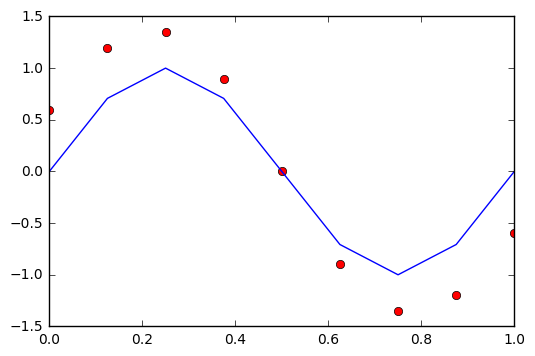

In [3]:
f = 4*pi**2*sin(2*pi*x)
u = linalg.solve(A, f)
uex = sin(2*pi*x)

plot(x,u,'ro')
plot(x,uex)

We see that there is a large error at the boundary points. This is due to boundary conditions, which are not taken into account in this case. Consider the even simpler case, where $f=1$ everywhere. The exact solution in this case is given by 

$$
u = \frac{x(1-x)}{2}
$$

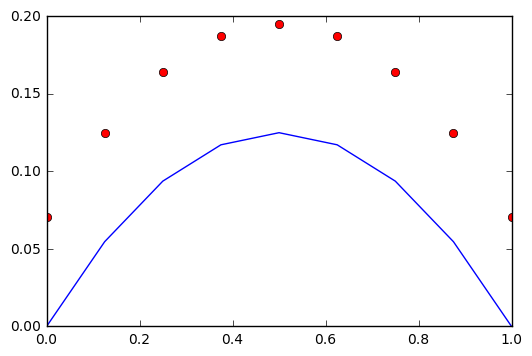

In [4]:
f1 = ones_like(x)
u1 = linalg.solve(A, f1)

u1ex = x*(1-x)/2

plot(x,u1,'ro')
plot(x, u1ex)

What is happening here, is that the matrix A is solving a different problem: one where the considered points are all internals, and the domain where we are solving the homogeneous laplace problem is actually $[-h,1+h]$...

To get better results, we need to impose the boundary conditions on the first and last point. How do we do this? One possibility is to replace the first and last line of the matrix (corresponding to the equation that we want to be satisfied for u at x=0 and x=1) and replace it with the boundary condition:

Error without bc: 0.595683320009
Error with    bc: 0.0530292875455


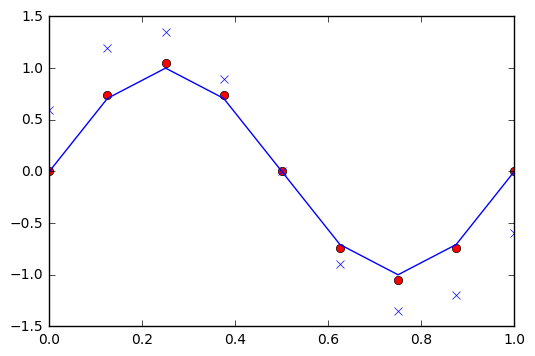

In [5]:
# Keep a copy of the matrix around, to compare the results
A1 = A.copy()

# Put a one on the diagonal in the first and last lines
A1[0,:] = 0
A1[0,0] = 1

A1[-1,:] = 0
A1[-1,-1] = 1

# Set to zero (the boundary condition) the right hand side corresponding to the first and last points
f2 = f.copy()
f[0] = 0
f[-1] = 0

u2 = linalg.solve(A1, f2)

plot(x,u2,'ro')
plot(x,u, 'bx')
plot(x,uex)

print("Error without bc:", (u-uex).max())
print("Error with    bc:", (u2-uex).max())

Much better results are obtained in the case of the quadratic problem too....

Error without bc: 0.0703125
Error with    bc: -0.0


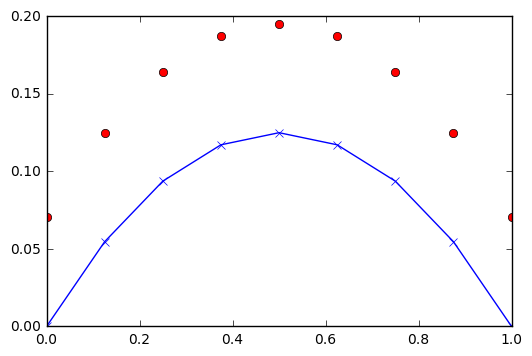

In [6]:
f3 = f1.copy()
f3[0]  = 0
f3[-1] = 0

u3 = linalg.solve(A1, f3)

plot(x,u1,'ro')
plot(x,u3, 'bx')
plot(x,u1ex)

print("Error without bc:", (u1-u1ex).max())
print("Error with    bc:", (u3-u1ex).max())

In this case, we observe that the error for the quadratic function is exactly zero. This is expected, since we are approximating by finite differences a function which is quadratic, and the algorithm we wrote is exact for quadratic functions, i.e., for functions where the second derivative is a constant.

Now try to compute the **rate** of the error for the first case of the **sinusoidal** forcing term, by performing the above steps in a cycle and increasing the number of points in powers of two, i.e., for h=1/2, 1/4, 1/8, 1/32, 1/64, 1/128, etc. and plot the $L^\infty$ error of the solution at the sample points VS the sampling space h.

In [7]:
# YOUR CODE HERE

# Finite element formulation

Find $u_h(x) :=  u^i v_i(x)$ s.t.

$$
-u_h''(x) = f(x)\ \mathrm{ in }\ [0,1]
$$

$$
u_h(0) = 0, \quad u_h(1) = 0
$$

# Weak Form

Given $V_h := \mathrm{span}\{\phi_i(x)\}_{i=0}^{n-1}$.
Find $u_h(x) \in V_h$ s.t.

$$
\int_{0}^1 u_h'\, \phi_i' = \int_0^1 f(x)\, \phi_i, \quad i = 0,\ldots, n-1
$$

$$
\int_{0}^1 u_h'\, \phi_i' = \left(\int_{0}^1 \phi_j'\, \phi_i'\right)\, u^j 
$$

This results in the following matrix:

$$
A_{ij} = \left(\int_{0}^1 \phi_j'\, \phi_i'\right)
$$

In order to perform this integration, we use some quadrature rules, chosen so that the product above is integrated exactly.

We do things in a slightly more general way this time, i.e, we start by defining the **Local Finite Element Space** of order $k$, defined using $\hat T := [0,1]$ (the **reference element**), $\hat{\mathcal{P}}^k([0,1])$ (the **local polynomial space**), and $\hat N$ (the **set of nodal functions**, that are a basis for the dual space of $\hat{\mathcal{P}}^k([0,1])$). 

We define everything in a very general way, so that we can extend it to high order polynomials (or two dimensions) in no time.

The basis functions, $V = \{v_i\}_{i=0}^{n-1}$, are defined implicitly, imposing orthogonality with $N := \{v^i\}_{i=0}^{n-1}$, i.e., $v^j(v_i) = \delta^j_i$.

In order for this to work, we need to first start from a known basis for $\mathcal{P}^k([0,1]) = \textrm{span}\{e_i\}_{i=0}^k =: \textrm{span} E$, and re-write our basis $V$ in terms of $E$.

$$
e_i = pow(x,i), \qquad v_i = v_i^k e_k \qquad v^j(v_i) = v^j(e_k) v^k_i 
$$

For each basis function $v_i$, we need to solve a system of equations in the $n$ unkonwns $v_i^k$ (free index $k$). Once this is done, we have our new polynomial basis functions (the **canonical basis** with respect to $N$):

$$
v^j(e_k) v^k_i  = C^j_k v^k_i = \delta^j_i \qquad i = 0, \ldots, n-1
$$

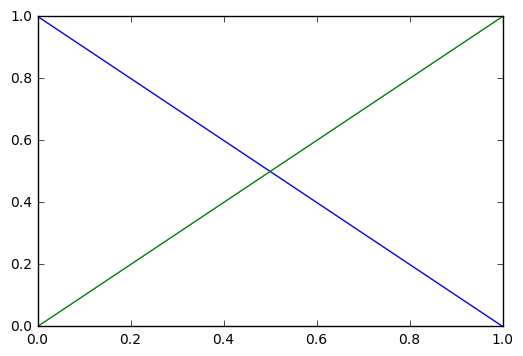

In [8]:
from numpy.polynomial.polynomial import *

# Start by defining the local dual basis functions. These are linear functions on polynomials with
# values in R.
N = []

N.append(lambda f: f(0))  # Evaluation of f at x = 0

# For quadratic
# N.append(lambda f: f(.5)) # Evaluation of f at x = .5 

# For cubic
# N.append(lambda f: f(1./3.))
# N.append(lambda f: f(2./3.))

N.append(lambda f: f(1))  # Evaluation of f at x = 1

# Dimension of the polynomial space
n = len(N) 

# Construct the local space V, as the set of polynomials of order len(N)-1 such that the 
# dual basis above, evaluated on the basis, gives the identity matrix. We start by defining 
# monomials, so that we can use numpy Polynomial package
E = []
for i in range(len(N)):
    c = zeros((i+1,))
    c[-1] = 1
    E.append(Polynomial(c)) # Now E[i] contains the monomial x^i

show()
# Construct the actual basis in terms of monomials,
# By solving for each basis a change of coordinate system
C = zeros((n,n)) # Matrix for the change of variables
for i in range(n):
    for j in range(n):
        C[i,j] = N[i](E[j])

# Auxiliary space to plot the result
s = linspace(0,1,1025)
V = []
for k in range(n):
    ei = zeros((n,))
    ei[k] = 1. # delta_ik
    vk = linalg.solve(C, ei)
    V.append(Polynomial(vk)) # Construct the basis using the right coefficients of the polynomials
    plot(s, V[k](s))

Now we have our local basis functions, constructed using **exclusively** the definition of the **Finite Element**, i.e., a reference element ([0,1]), a polynomial space, and a basis for the dual of the polynomial space.

# Coordinate transformations on each element

Let's now split the integral on $[0,1]$ as an integral on $[x_i, x_{i+1}]$:

$$
\int_0^1 f(x) dx = \sum_{i=0}^{n-1} \int_{x_i}^{x_{i+1}} f(x) dx = \sum_{i=0}^{n-1} \int_0^1 f(T_i(\xi)) |T_i'(\xi)| d\xi  \qquad T_i(\xi) = x_i +(x_{i+1}-x_i) \xi = x_i +h \xi 
$$

Where the transformation $T_i(\xi)$ is used to perform all integrals on the same interval.

In general the integral on $[0,1]$ is performed using quadrature rules, i.e.,

$$
\int_0^1 g(\xi) d\xi = \sum_{q=0}^{nq} g(\xi_q) w_q
$$

Once we have **local basis functions**, they are transformed to **global basis functions** by the following relation:

$$
\phi_{k(i,m)}(T_i(\xi)) := v_m(\xi)
$$

similarly for the derivatives:

$$
\phi'_{k(i,m)}(T_i(\xi)) := v'_m(\xi) T'_i(\xi)^{-1} = \frac{v'_m(\xi)}{h}, \qquad m = 0, \ldots, len(N)-1,
$$

giving the following final system for the **Finite Element Assembly**:

$$
A_{ij} = \int_0^1 \phi'_i(x)\phi_j'(x) dx = \sum_{\ell=0}^{n-1} \sum_{q=0}^{nq} \frac{v'_{m(i,\ell)}(\xi_q)}{h}\frac{v'_{n(j,\ell)}(\xi_q)}{h} h w_q \qquad \text{ if } \mathrm{supp}\{ \phi_j \}\cap \mathrm{supp}  \{\phi_i \}\neq \emptyset
$$


That is, global basis functions are obtained by the **push forward** through $T_i$ of local basis functions. The local basis functions and their derivatives can be evaluated once and for all at the quadrature points, and then assembled globally by recognizing where the local degree of freedom maps in the global numbering (i.e., the mapping of $m$ and $n$ to $i$ and $j$ in the equation above). This mapping is usually evaluated the other way around, i.e., from local to global instead of from global to local.

Notice that the mapping of the local degrees of freedom to the global degrees of freedom, and the structure of the local basis functions is what decides wether globally $\phi_i$ are continuous.

For the one dimensional case, if the dual basis contains the Dirac delta distribution centered at the two extremes of the reference interval (as in the example above), then the Finite Element may be continuous or not, according to how the global numbering depends on the local numbering: if the **numbering** of the first global degree of freedom of an element coincides with the numbering of the last global degree of freedom of the previous element, then we obtain a continuous finite element space, otherwise we obtain a discontinuous one.

Let's explore this concept. We first define a quadrature formula on the reference interval $[0,1]$, so that integrating a product of basis functions, we get exact integrals.

In [9]:
from numpy.polynomial.legendre import leggauss

degree = 2*len(N)-1
q,w = leggauss(degree) # Gauss between -1 and 1
q = (q+1)/2 # Go back to 0,1 
w = w/2

print(q)

[ 0.11270167  0.5         0.88729833]


Now we evaluate all local basis functions and all derivatives of the basis functions at the quadrature points.

In [10]:
Vq = zeros((len(N), len(q)))
Vpq = zeros((len(N), len(q)))

for i in range(len(N)):
    Vq[i] = V[i](q)
    Vpq[i] = V[i].deriv()(q)

For each element, we know that there are `len(N)` local basis functions. The first and the last are shared by the previous and the following element if we want to impose continuity, therefore the global numbering, in each element, is simply given by `range(i*(len(N)-1), i*(len(N)-1)+len(N))`, and the total number of degrees of freedom is given by `(len(x)-1)*(len(N)-1)+1`.

If we wanted discontinous elements, then there would simply be a total of `(len(x)-1)*len(N)` basis functions, with global indices given by `range(i*len(N), (i+1)*len(N))`.

In [11]:
n_dofs = (len(x)-1)*(len(N)-1)+1

A2 = zeros((n_dofs, n_dofs))
rhs = zeros((n_dofs,))

myf = lambda x: 4*pi**2*sin(2*pi*x)

# Construct the local matrix only once:
local_A = einsum('jq, iq, q -> ij', Vpq/h, Vpq/h, w*h)

for i in range(len(x)-1):
    start = i*(len(N)-1)
    end = start+len(N)
    
    index = range(start, end)
    A2[ix_(index, index)] += local_A
    
    # The transformation of the quadrature points
    xq = x[i]+h*q
    local_rhs = einsum('iq, q, q -> i', Vq, w*h, myf(xq))
    
    rhs[index] += local_rhs

# Fix the boundary conditions
A2[0] = 0
A2[0,0] = 1
rhs[0] = 0

A2[-1] = 0
A2[-1,-1] = 1
rhs[-1] = 0

# Solve the system
ufem = linalg.solve(A2, rhs)

How do we know if we did a good job?

We write an interpolation matrix, that returns the function evaluated at the given points, once the coefficients are known, i.e.: 

$$
I_ij = \phi_i(x_j)
$$

The problem with this interpolation matrix, is that we don't know how to recover the global basis function $\phi_i$ at arbitrary points. We need to run over all intervals, construct the evaluation of the local function, and put it in the right spot in the global matrix:

In [12]:
def interpolation_matrix(s, x, V):
    """
    Given the evaluation points s in the mesh x, construct the interpolation matrix 
    according to the local basis V.
    """
    n_dofs = (len(x)-1)*(len(V)-1)+1

    M = zeros((n_dofs, len(s)))
    for i in range(len(x)-1):
        index = s>=x[i]
        index *= s<=x[i+1]
        
        # Transform the points to [0,1]
        xi = (s[index]-x[i])/(x[i+1]-x[i])
        
        for j in range(len(V)):
            k = i*(len(N)-1)+j
            M[k,index] = V[j](xi)
    return M

Now that we have the interpolation matrix, we can construct the Finite Element Interpolant

Error at the s points: 0.0703767478793
Error at the x points: 5.99610066487e-07


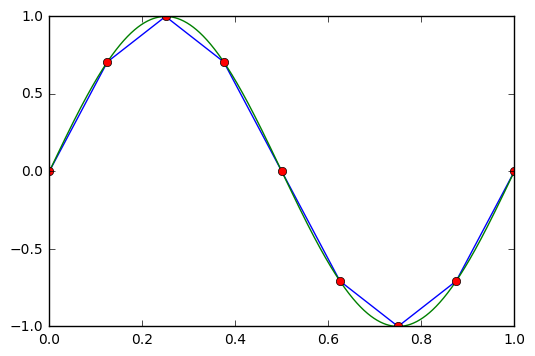

In [13]:
s = linspace(0,1,1025)
us = sin(2*pi*s)
ux = sin(2*pi*x)

# Use this to plot high resolution versions
M = interpolation_matrix(s,x,V)

# Use this to compute errors at the mesh points
Mx = interpolation_matrix(x,x,V)

plot(s, M.T.dot(ufem))
plot(s, us)
plot(x, ux,'ro')

print("Error at the s points:", (M.T.dot(ufem)-us).max())
print("Error at the x points:", (Mx.T.dot(ufem)-ux).max())

The Matrix is always assembled **exactly**. What happens if we improve the quadrature formula for the right hand side?

Try assemblying again the right hand side using a better quadrature formula, and compute the error **at the mesh points** when increasing the accuracy of the integration on the right hand side (remember: for linear functions, the matrix is the same as the finite difference matrix. The only difference can then come from the right hand side).

In [14]:
# YOUR CODE HERE